# Avalanche Prediction via Machine Learning (so I begin...)

## Introduction
This is the first step of what I hope will be many in utilizing machine learning techniques to predict avalanche phenomena. In this notebook, I'm aim to present a little example of this by using a support vector machine (SVM) and three freely available datasets to predict avalanche detection (you'll see here soon why I wrote avalanche *detection* and not avalanche *occurrence*). Let's begin with the most important part, the data:.

## A. The datasets
For simplicities sake, I only looked at data from the current winter, Oct 1, 2019 to April 4, 2020.

In [7]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

start_time = pd.Timestamp("2019-10-01 00:00:00")
end_time = pd.Timestamp("2020-04-04 00:00:00")

### 1. Avalanches: 
The first dataset I got my hands on was from the Utah Avalanche Center. They have a [database of avalanches](https://utahavalanchecenter.org/avalanches) that goes all the way back to 1914. My mom's dad was 3 at the time. It's awesome. There's lots of great info in there. But alas, right off the bat we have a huge caveat to add to any conclusion that can be drawn with this data: this isn't a table of avalanches; it's a table of __*avalanche reportings*__. Thus, basically any model that uses this data is only going to be able to predict if somebody will __*see and report*__ an avalanche not that an avalanche occurs.

One idea for the future would be to use satellite imagery to detect avalanches. If the imagery is high res enough, a machine could be trained to detect them and provide coordinates. This would also provide the benefit of allowing both the slope angle and elevation to be calculated. Unfortunately, some days it's cloudy (NO WAY!), so this wouldn't provide comprehensive avalanche detection. Just spitballing.

For simplicity, I subsetted the data to only include avalanche reports from the "Salt Lake" region.

In [8]:
avy_data = pd.read_csv("avalanches.csv", parse_dates=['Date'])
avy_data = avy_data.rename(columns={'Date': 'date'})

# only Salt Lake
avy_data = avy_data.loc[avy_data.Region == 'Salt Lake']

# subset select time period
avy_data = avy_data[((avy_data.date >= start_time + pd.Timedelta(days=1)) &
                     (avy_data.date <= end_time))]

# count avalanches reported per day
avy_count = avy_data.date.value_counts()

# fill in missing datetimes
idx = pd.date_range(start_time + pd.Timedelta(days=1), end_time)
avy_count = avy_count.reindex(idx)
avy_count = avy_count.fillna(0)

# convert to any avalanche seen vs no avalanches seen
avy = avy_count.astype(bool).astype(int)
avy = avy.to_numpy()

### 2. Snow data:
SNOTEL has a pretty easy-to-use [web interface](http://wcc.sc.egov.usda.gov/reportGenerator/) to get information from their SNOTEL sites. For the current exploratory mission, I just used data from SITE 628 - "MILL-D NORTH". At this site, there are four measurements recorded: snow-water equivalent, snow depth, precipitation accumulation, and temperature. I didn't use precipitation accumulation because I don't really know what that means in this context (I haven't had time to figure out yet (April 17, 2020)). These measurements are taken hourly. There are a few lapses (I wanna say 300 bad recordings out of 13,000). I just interpolated to fill them in.

In [3]:
snotel = pd.read_csv("snotel.csv", parse_dates=['Date'])


# subset for select time period
snotel = snotel[(snotel.Date > start_time + pd.Timedelta(hours=9)) &
                (snotel.Date <= end_time + pd.Timedelta(hours=9))]

# fill in missing dates
snotel = snotel.set_index(['Date'])
idx = pd.date_range(snotel.index.min(), snotel.index.max(), freq='H')
snotel = snotel.reindex(idx)

# find nulls and interpolate
snotel = snotel.interpolate(axis=0)

### 3. Wind and Sky Cover data:
This data was surprisingly hard to find. I would think that there would be publicly available, hourly recordings of wind speed and direction recorded at elevations above 10,000 ft in the Wasatch but I couldn't find any (like at a resort's weather station?). I figured finding sky cover data would be more difficult. 

I found hourly recordings of both variables at a [NOAA website](https://www.ncdc.noaa.gov/cdo-web/). They were recorded at the Salt Lake Airport. The wind speed is just plain ole wind speed but the sky cover measurement is more abstruse. I'm gonna pull a tenured professor move and encourage the interested reader to read the [documentation](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/NORMAL_HLY_documentation.pdf). I dropped all other remaining variables.

I'm not going to bore you by describing how I cleaned the data/dealt with it's eccentricities.

In [4]:
# convert feet or inches to inches
def conv_to_in(x):
    if x.endswith("'"):
        return float(x[:-1]) * 12
    if x.endswith('"'):
        return float(x[:-1])


# convert feet or inches to feet
def conv_to_ft(x):
    x = x.replace(',', '')
    if x.endswith("'"):
        return float(x[:-1])
    if x.endswith('"'):
        return float(x[:-1]) / 12


# parse sky_unparsed column
def parse_sky(x):
    if pd.isna(x):
        return x
    else:
        pieces = x.split()

        if len(pieces) == 1:
            return 0
        else:
            highest = pieces[-2]
            return int(highest[4:6])

# noaa = pd.read_csv("noaa.csv", 
#                    usecols= ['DATE', 'HourlySkyConditions', 'HourlyWindSpeed'],
#                    parse_dates=['DATE'])
# type(noaa.loc[0,'HourlyWindSpeed'])

noaa = pd.read_csv("noaa.csv", 
                   usecols= ['DATE', 'HourlySkyConditions', 'HourlyWindSpeed'],
                   dtype={'HourlySkyConditions': str, 'HourlyWindSpeed': str},
                   parse_dates=['DATE'])

noaa = noaa.rename(columns={'DATE': 'date',
                            'HourlySkyConditions': 'sky_unparsed',
                            'HourlyWindSpeed': 'windspeed'})

# subset for select time period
noaa = noaa[(noaa.date > start_time + pd.Timedelta(hours=9)) &
            (noaa.date <= end_time + pd.Timedelta(hours=9))]

# get rid of rows that don't make sense (are just a number)
noaa = noaa.loc[~(noaa['sky_unparsed'].apply(lambda x: str(x).isdigit()))]

# parse sky_unparsed column
noaa['sky'] = noaa['sky_unparsed'].apply(lambda x: parse_sky(x))
noaa = noaa.drop(['sky_unparsed'], axis=1)

# clean windspeed data
noaa['windspeed'] = noaa['windspeed'].replace('NaN', pd.NA).astype(float)

# interpolate the missing data
noaa = noaa.interpolate(axis=0)

# round datetimes
noaa['date'] = noaa['date'].apply(lambda x: x.round('60min'))

# remove rows with duplicate datetimes
noaa = noaa.drop_duplicates('date')

# fill in missing datetimes
noaa = noaa.set_index(['date'])
idx = pd.date_range(noaa.index.min(), noaa.index.max(), freq='H')
noaa = noaa.reindex(idx)
noaa = noaa.interpolate(axis=0)

# combine with snotel data
exog_og = noaa.join(snotel)
exog_og = exog_og.to_numpy()

A keen observer will notice that the avalanche detection data is recorded by day but the weather data is by hour. How am I going to put these things together? Well, I associate one day's avalanche happenings with 24 hours of weather data concluding at 9am on that one day.

That 24 hours of weather data is a table/matrix of size $24 \times 5$ (24 hours by 5 variables: snow depth, snow water equivalent, temperature, wind speed, sky cover). For every day, I flattened the $24 \times 5$-sized table into a row of length 120. Thus, over the 186 days in our study period, all the data becomes a table of size $186 \times 120$. 

There's a few things to note:
1. Yes, the way the data is structured now there are a ton of variables compared to the amount of days. Well, in the future we'll have at least 10 times as many days using previous winters (probably more like 20 times as many) just in Salt Lake.
2. Note that successive measurements of each variable are autocorrelated (measurements taken closer together in time are more likely to be similar). So there aren't really 120 completely different variables. I believe that there is a possibility to use principle component analysis here.
3. Variables are still autocorrelated across days. This is good information in the data that I'm not utilizing for the sake of simplicity. I've seen some discussion about using convolutional neural networks for studying time sereis data. This could be a potential avenue for discovery.

In [5]:
# flatten days
study_interval = (end_time - start_time).days
exog = [exog_og[i*24:(i+1)*24].flatten() for i in range(0, study_interval)]
exog = np.asarray(exog)

## B. Training and Testing
Finally! Funny how the fun part at the end really doesn't take anytime at all. Now we fit a support vector machine to our data. I did a little bit of tuning and found that a ```gamma``` between ```0.00001``` and ```0.000001``` works best. ```C``` is the amount of regularization that is added (higher ```C``` is less regularization). ```C``` doesn't seem to have much effect between ```1``` and ```1000```. I'm seeing accuracies around 75% to 85%.

I'm stoked to see this, to be honest. I imported little of the available data, threw away plenty of information within the data I did import, and used a classifier that isn't known for use in studying time series. For a first shot, I'm happy.

Classification report for classifier SVC(C=100, gamma=1e-06):
              precision    recall  f1-score   support

           0       0.93      0.60      0.73        45
           1       0.72      0.96      0.82        48

    accuracy                           0.78        93
   macro avg       0.82      0.78      0.78        93
weighted avg       0.82      0.78      0.78        93




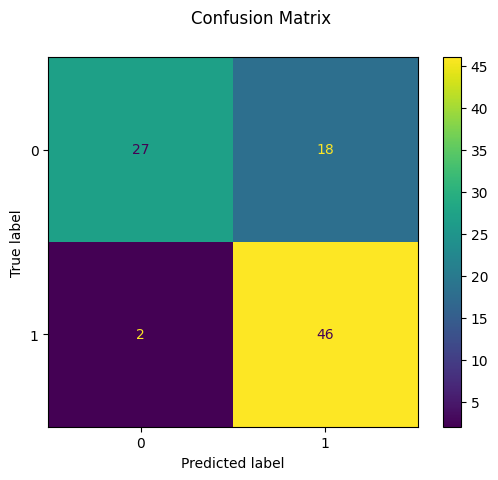

In [10]:
svm_clf = svm.SVC(gamma=0.000001, C=100)
X_train, X_test, y_train, y_test = train_test_split(exog,
                                                    avy,
                                                    test_size=0.5,
                                                    shuffle=True)
svm_clf.fit(X_train, y_train)
predicted = svm_clf.predict(X_test)

# Some results for kicks
print("Classification report for classifier %s:\n%s\n"
      % (svm_clf, classification_report(y_test, predicted)))
disp = ConfusionMatrixDisplay.from_estimator(svm_clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

## C. Future plans
1. Of course the next step is to us more winters of data. I need to study the Utah Avalanche Center dataset more to see how many years back the data is usable.
2. Principle component analysis to investigate possibly simplifying the set of variables
3. [Convolutional Neural Networks](https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/) Just an idea